In [1]:
library(randomForest)
library(caret)
library(party)
library(rpart)
library(rpart.plot)
library(caTools)
library(dplyr)
library(ROCR)
library(e1071)

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.
Loading required package: lattice
Loading required package: ggplot2

Attaching package: 'ggplot2'

The following object is masked from 'package:randomForest':

    margin

Warning message:
"package 'party' was built under R version 3.4.1"Loading required package: grid
Loading required package: mvtnorm
Loading required package: modeltools
Loading required package: stats4
Loading required package: strucchange
Warning message:
"package 'strucchange' was built under R version 3.4.1"Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: sandwich
Warning message:
"package 'sandwich' was built under R version 3.4.1"Warning message:
"package 'rpart' was built under R version 3.4.1"Warning message:
"package 'rpart.plot' was built under R version 3.4.1"
Attaching package: 'dplyr'

The following object is masked f

In [2]:
set.seed(2017)
N  <- 10000
x1 <- rnorm(N, sd=1.5)
x2 <- rnorm(N, sd=1.5)
y  <- apply(cbind(x1, x2), 1, function(x) xor(xor((x%*%x)<5.5, (x%*%x)>2),(x%*%x)<0.75))
# y  <- apply(cbind(x1, x2), 1, function(x) (x%*%x)<5)

In [3]:
data_junk <- matrix(rnorm(N*10, sd=1.5), ncol=10)
colnames(data_junk) <- paste(paste("x", 3:(ncol(data_junk)+2), sep=""))
data <- cbind(x1, x2, data_junk,y)
data <- data.frame(data)
data$y <- as.factor(data$y)

In [4]:
data$y[abs(data$x1-data$x2) <0.5] <- 0

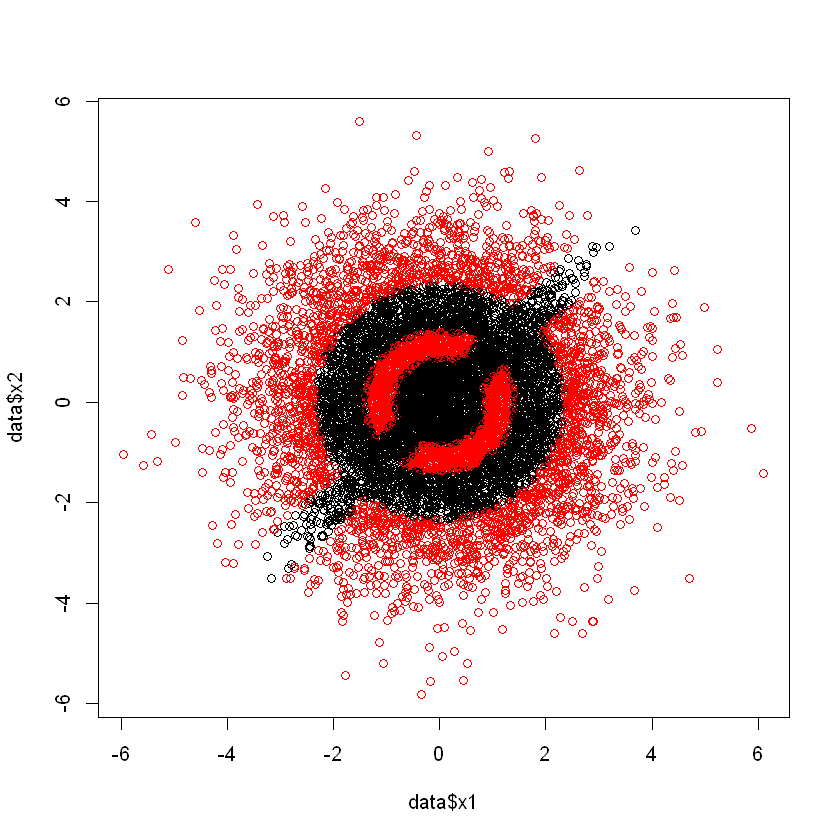

In [5]:
plot(data$x1, data$x2, col=ifelse(data$y==0, "black", "red"))

In [65]:
summary(data)

       x1                  x2                  x3           
 Min.   :-5.956246   Min.   :-5.825344   Min.   :-5.566368  
 1st Qu.:-1.050943   1st Qu.:-0.994469   1st Qu.:-0.997728  
 Median : 0.002499   Median : 0.015556   Median : 0.019896  
 Mean   :-0.006710   Mean   : 0.000589   Mean   : 0.007801  
 3rd Qu.: 1.023922   3rd Qu.: 1.010299   3rd Qu.: 1.015419  
 Max.   : 6.111088   Max.   : 5.595424   Max.   : 7.083721  
       x4                  x5                 x6                  x7           
 Min.   :-5.828862   Min.   :-5.11689   Min.   :-5.231217   Min.   :-5.813473  
 1st Qu.:-1.016531   1st Qu.:-1.03548   1st Qu.:-1.049658   1st Qu.:-1.005816  
 Median :-0.003373   Median :-0.01092   Median :-0.022800   Median : 0.013423  
 Mean   :-0.011556   Mean   :-0.00883   Mean   :-0.009661   Mean   : 0.000588  
 3rd Qu.: 0.998172   3rd Qu.: 0.99266   3rd Qu.: 1.013347   3rd Qu.: 1.025352  
 Max.   : 5.703312   Max.   : 5.25912   Max.   : 5.323360   Max.   : 6.266635  
       x8    

In [66]:
data$x13 <- (data$x1)^2
data$x14 <- (data$x2)^2

In [71]:
data$split1 <- sample.split(data$y, SplitRatio=0.5)
train <- subset(data, data$split==TRUE)
test <- subset(data, data$split==FALSE)
data$split1 <- NULL
train$split1 <- NULL
test$split1 <- NULL
rawtrain <- train
rawtest <- test

In [72]:
train <- rawtrain
test <- rawtest

# Random Forest

In [73]:
rf <- randomForest(as.factor(y)~., data=train, ntree=500,importance=TRUE)

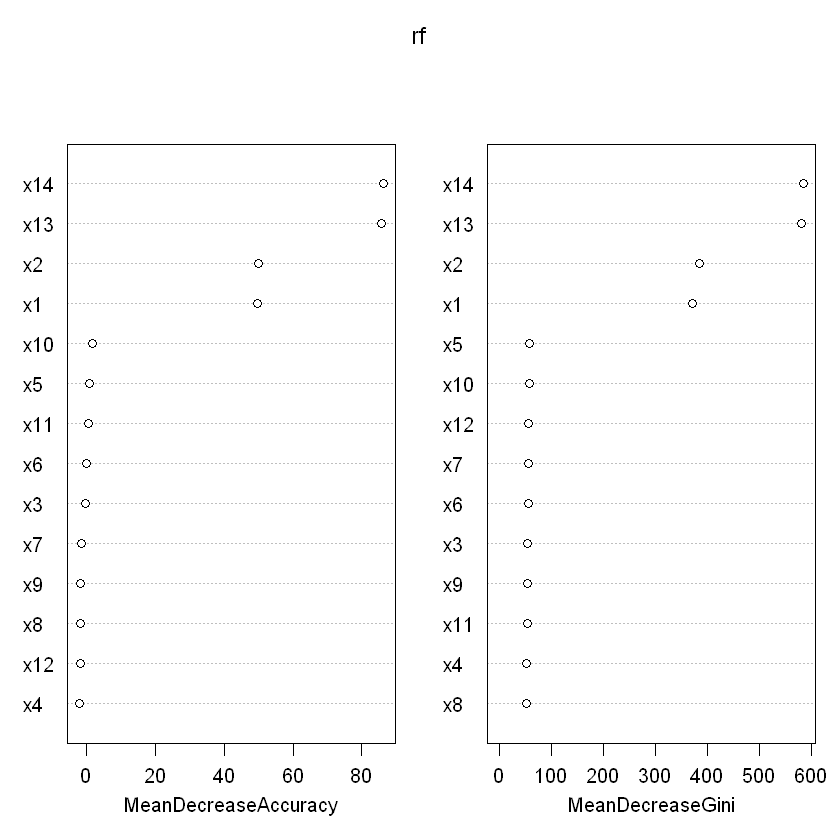

In [74]:
varImpPlot(rf)

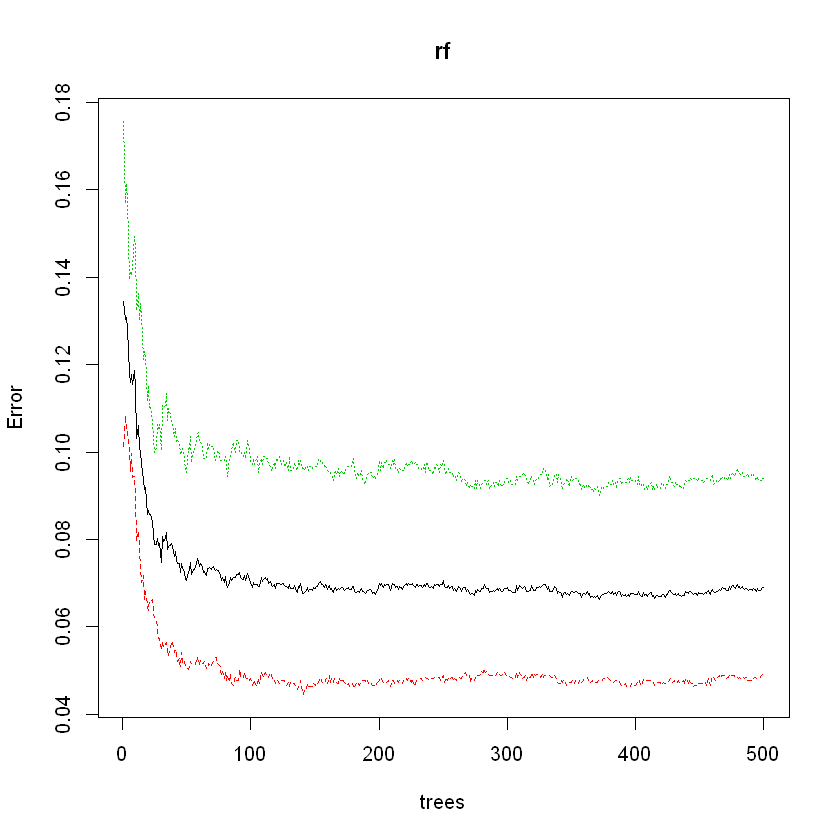

In [75]:
plot(rf)

In [76]:
test$predicted <- predict(rf,test,type="response")
test$predicted <- as.factor(test$predicted)
confusionMatrix(test$predicted, test$y)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2656  179
         1  132 2033
                                          
               Accuracy : 0.9378          
                 95% CI : (0.9307, 0.9443)
    No Information Rate : 0.5576          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.8736          
 Mcnemar's Test P-Value : 0.009096        
                                          
            Sensitivity : 0.9527          
            Specificity : 0.9191          
         Pos Pred Value : 0.9369          
         Neg Pred Value : 0.9390          
             Prevalence : 0.5576          
         Detection Rate : 0.5312          
   Detection Prevalence : 0.5670          
      Balanced Accuracy : 0.9359          
                                          
       'Positive' Class : 0               
                                          

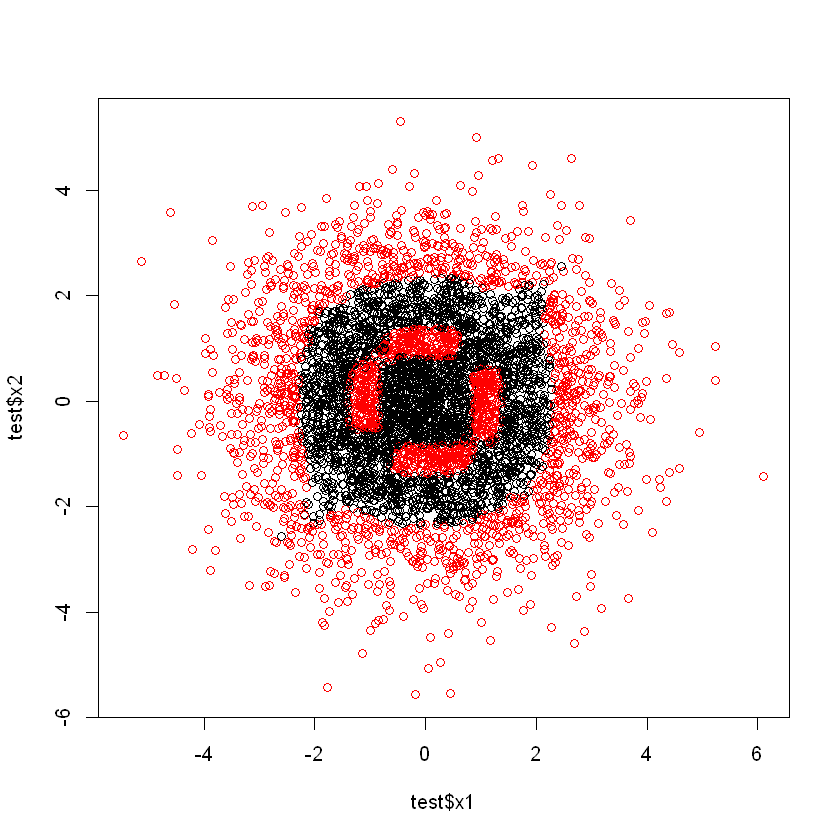

In [77]:
plot(test$x1, test$x2, col=ifelse(test$predicted==0, "black", "red"))

# Logistic Regression

In [80]:
train <- rawtrain
test <- rawtest

In [81]:
logit <- glm(y~x13*x14, data=train, family="binomial")
summary(logit)


Call:
glm(formula = y ~ x13 * x14, family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1041  -0.9273  -0.6295   0.8878   1.7757  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.610107   0.056704 -28.395  < 2e-16 ***
x13          0.358042   0.017608  20.334  < 2e-16 ***
x14          0.357754   0.017633  20.289  < 2e-16 ***
x13:x14     -0.035097   0.004936  -7.111 1.16e-12 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 6865.0  on 4999  degrees of freedom
Residual deviance: 5613.8  on 4996  degrees of freedom
AIC: 5621.8

Number of Fisher Scoring iterations: 4


In [86]:
test$predicted <- round(predict(logit,test,type="response"))
test$predicted <- as.factor(test$predicted)
confusionMatrix(test$predicted, test$y)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2432  813
         1  356 1399
                                          
               Accuracy : 0.7662          
                 95% CI : (0.7542, 0.7779)
    No Information Rate : 0.5576          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5158          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.8723          
            Specificity : 0.6325          
         Pos Pred Value : 0.7495          
         Neg Pred Value : 0.7972          
             Prevalence : 0.5576          
         Detection Rate : 0.4864          
   Detection Prevalence : 0.6490          
      Balanced Accuracy : 0.7524          
                                          
       'Positive' Class : 0               
                                          

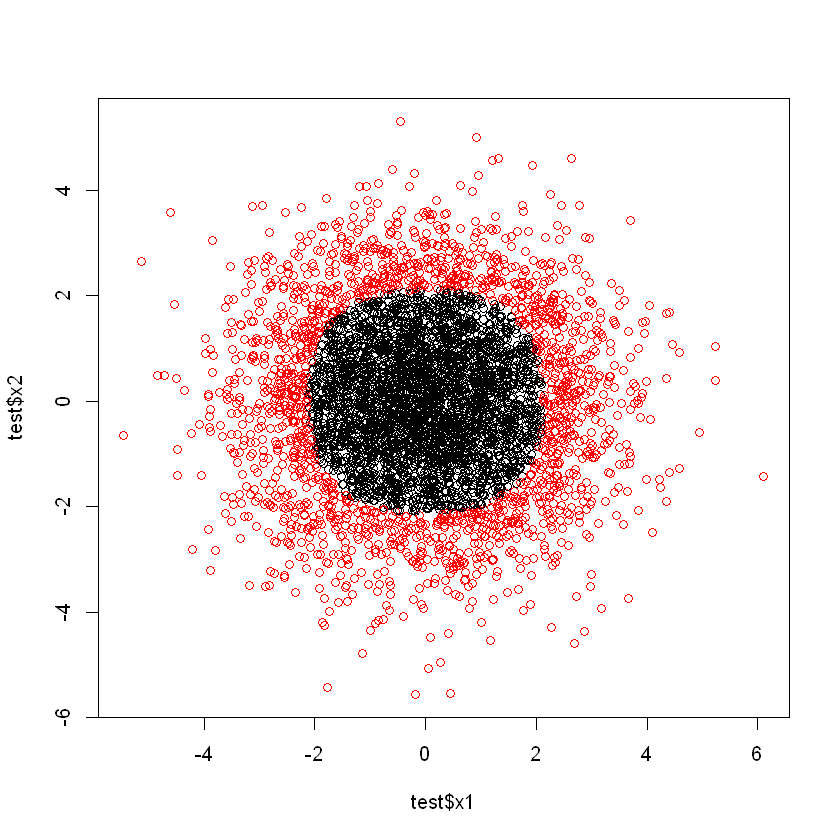

In [87]:
plot(test$x1, test$x2, col=ifelse(test$predicted==0, "black", "red"))

# Decision Tree

In [14]:
train <- rawtrain
test <- rawtest

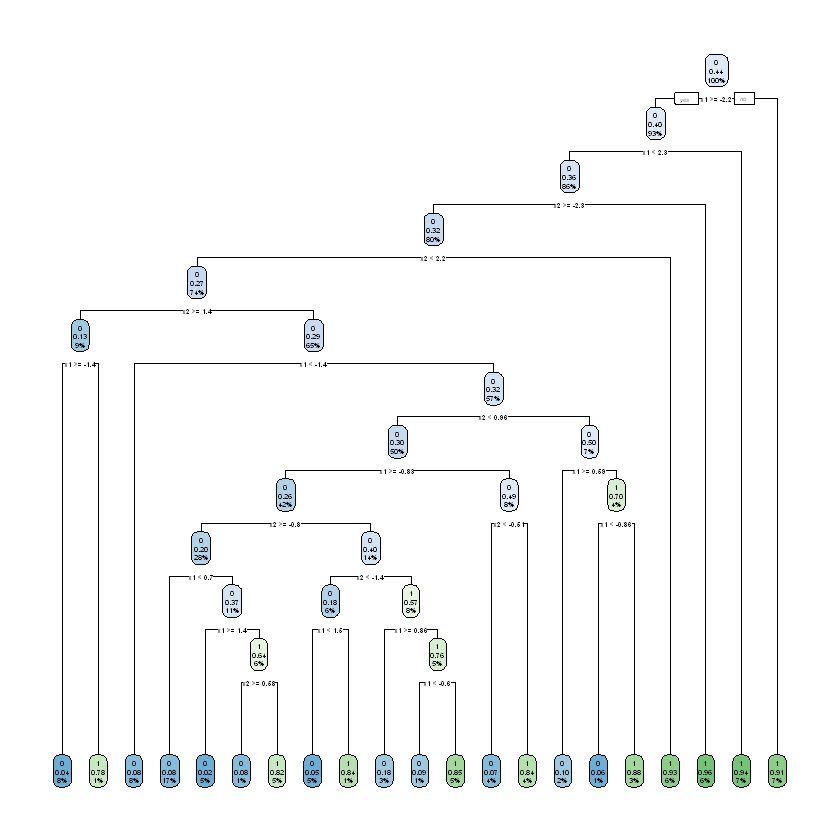

In [15]:
rtree_fit <- rpart(y ~ ., train) 
rpart.plot(rtree_fit)

In [16]:
test$predicted <- predict(rtree_fit, test,type = "class")
test$predicted <- as.factor(test$predicted)
confusionMatrix(test$predicted, test$y)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2504  231
         1  284 1981
                                          
               Accuracy : 0.897           
                 95% CI : (0.8882, 0.9053)
    No Information Rate : 0.5576          
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.7917          
 Mcnemar's Test P-Value : 0.02194         
                                          
            Sensitivity : 0.8981          
            Specificity : 0.8956          
         Pos Pred Value : 0.9155          
         Neg Pred Value : 0.8746          
             Prevalence : 0.5576          
         Detection Rate : 0.5008          
   Detection Prevalence : 0.5470          
      Balanced Accuracy : 0.8969          
                                          
       'Positive' Class : 0               
                                          

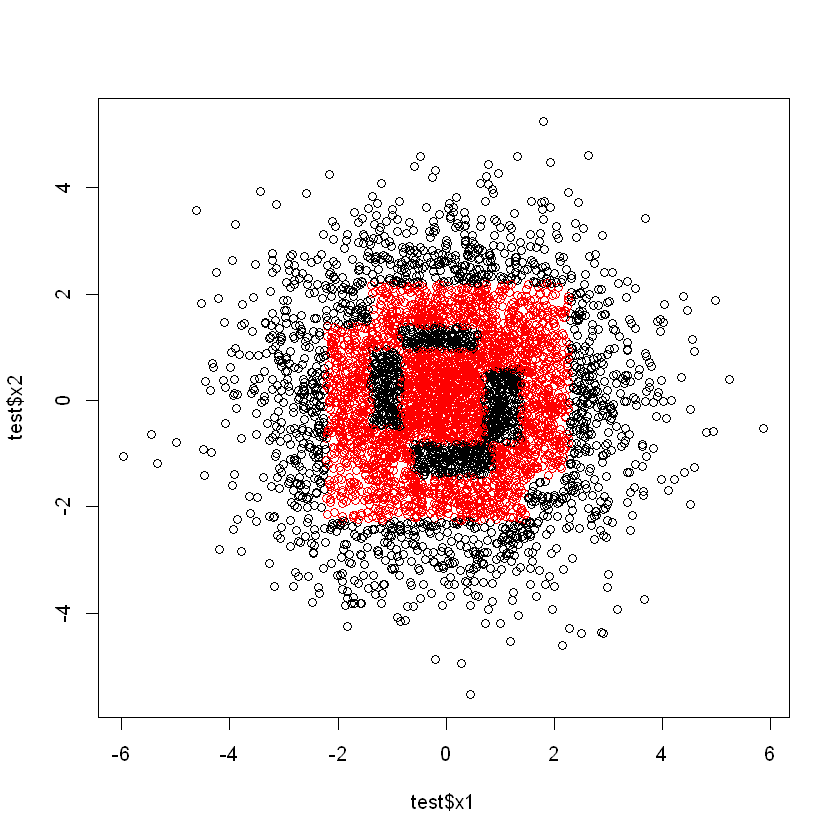

In [17]:
plot(test$x1, test$x2, col=ifelse(test$predicted==0, "red", "black"))

In [18]:
train <- rawtrain
test <- rawtest

In [19]:
fit.svm <-  svm(y~., data=train, kernel="radial")

In [20]:
test$predicted <- predict(fit.svm, test,type = "response")
test$predicted <- as.factor(test$predicted)
confusionMatrix(test$predicted, test$y)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2458 1038
         1  330 1174
                                          
               Accuracy : 0.7264          
                 95% CI : (0.7138, 0.7387)
    No Information Rate : 0.5576          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4265          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.8816          
            Specificity : 0.5307          
         Pos Pred Value : 0.7031          
         Neg Pred Value : 0.7806          
             Prevalence : 0.5576          
         Detection Rate : 0.4916          
   Detection Prevalence : 0.6992          
      Balanced Accuracy : 0.7062          
                                          
       'Positive' Class : 0               
                                          

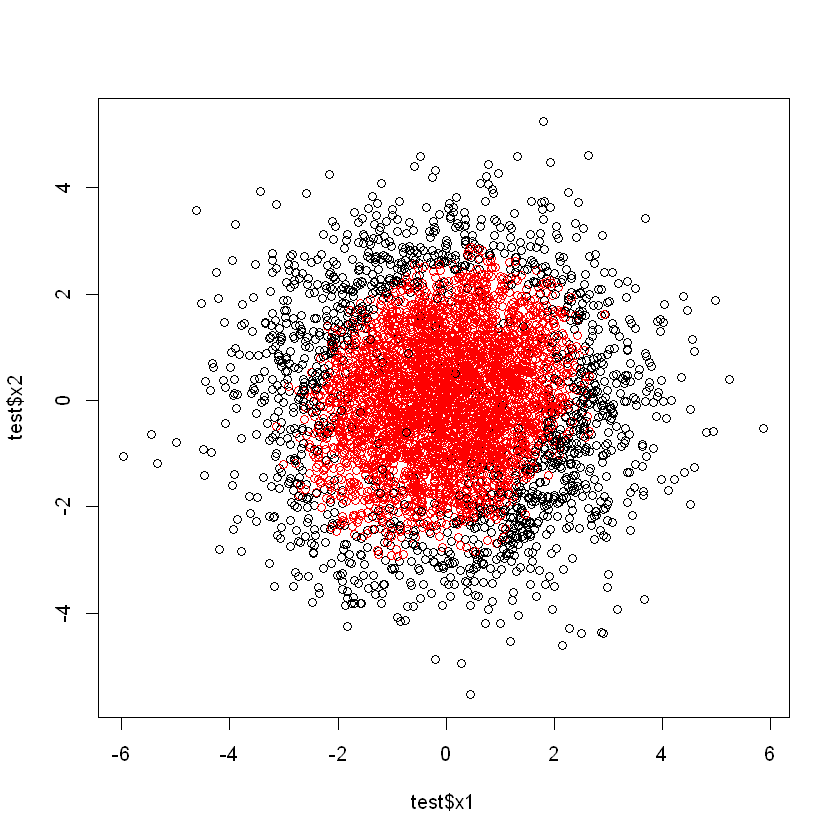

In [21]:
plot(test$x1, test$x2, col=ifelse(test$predicted==0, "red", "black"))

In [22]:
# write.csv(data, "simulate-police.csv")